In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import time
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [ ]:
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

Data Pre-processing:
- Tokenize, Stemming, Lemmatization
- Remove Stopwords, Special Characters, URLs

Focus on April 2022 and May 2023 datasets

In [ ]:
def load_data(file_path):

  df = pd.read_csv(file_path, on_bad_lines='skip')
  df = df[['text']]
  df = df.drop_duplicates()
  df = df.dropna()

  return df

In [ ]:
def clean_text(text):
  text = text.lower()
  text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
  text = re.sub(r'\@\w+|\#', '', text) # Remove mentions and hashtags
  text = re.sub(r'[^A-Za-z0-9 ]+', '', text) # Remove special characters, keep alphanumeric only

  # NOTE: VADER handles stopwords and doesn't require tokenization or stemming/lemmatization

  return text.strip()

In [ ]:
def calc_vader_compound(text):
  """
  Calculate VADER compound sentiment for the given text.
  negative, neutral and positive sentiments range from [0, 1]
  compound sentiment ranges from [=1, 1] and denotes overall sentiment
  compound ranges: negative[-1, -0.05), neutral[-0.05, 0.05], positive(0.05, 1]
  ---
  return: (compound_sentiment, sentiment_category)
          compound_sentiment - float - compound sentiment score
          sentiment_category - string - category of 'Positive', 'Neutral', or 'Negative'
  """

  SIA = SentimentIntensityAnalyzer()
  sentiment = SIA.polarity_scores(text)
  compound_sentiment = sentiment['compound']

  if compound_sentiment > 0.05:
    sentiment_category = 'Positive'
  elif compound_sentiment < -0.05:
    sentiment_category = 'Negative'
  else:
    sentiment_category = 'Neutral'

  return (compound_sentiment, sentiment_category)

In [ ]:
def calc_accuracy(predicted, actual):
    if len(predicted) != len(actual):
        raise ValueError("Both lists must have the same length.")

    correct = 0

    for i in range(len(predicted)):
        if predicted[i] == actual[i]:
            correct += 1

    return correct / len(predicted)

In [ ]:
def time_diff(start_time, end_time):
  """
  Calculates the time difference in minutes.
  ---
  returns: float - the time difference in minutes.
  """

  return (end_time - start_time) / 60

In [ ]:
def train_test_models(x_train, y_train, x_test, y_test):
  """
  Train the pre-set models, then evaluate their accuracy on a test set.
  Prints out the results (and the training time).
  ---
  returns: results - dict {string: float} - the models and their accuracies on the test set.
  """

  models = {
      'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=3),
      'Support Vector Machine': SVC(kernel='linear', random_state=42),
      'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
  }

  results = {}

  # Train the models, then evaluate their accuracy
  for name, model in models.items():
    print(f"Training {model}...")

    start = time.time()
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    end = time.time()

    process_time = time_diff(start, end)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Training time: {process_time:.2f} minutes")
    print(f"{name} Accuracy: {accuracy:.3f}\n")

    results[name] = accuracy

  return results

In [ ]:
input_file_path = "/content/data/08-19-2022.csv"
# output_file_path = "/content/res/08-19-2022.csv"

df = load_data(input_file_path)
df['text'] = df['text'].apply(clean_text)

start = time.time()
df[['compound_sentiment', 'sentiment_category']] = df['text'].apply(calc_vader_compound).apply(pd.Series)
end = time.time()

process_time_in_min = time_diff(start, end)
print(f"Data Pre-processing time: {process_time_in_min} minutes")

df = df.drop(df[df['compound_sentiment'] == 0.0].index)
# NOTE: non-English tweets are included in the dataset and scored as 0.0000 Neutral
#       this is a destructive method of circumventing that by removing all 0.0000 tweets
#       it is expected that the information loss is minimal considering the rarity of exact 0.0000 scores

# df.to_csv(output_file_path, index=False)

Data Pre-processing time: 7.442505872249603 minutes


In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["text"])
Y = df["sentiment_category"].map({"Positive": 1, "Neutral": 0, "Negative": -1})

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
model_accuracies = train_test_models(x_train, y_train, x_test, y_test)

Training KNeighborsClassifier(n_neighbors=3)...
Training time: 0.06 minutes
K-Nearest Neighbors Accuracy: 0.777

Training SVC(kernel='linear', random_state=42)...
Training time: 2.94 minutes
Support Vector Machine Accuracy: 0.882

Training RandomForestClassifier(random_state=42)...
Training time: 2.05 minutes
Random Forest Accuracy: 0.834



In [ ]:
# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=3)

start = time.time()
knn.fit(X, Y)
end = time.time()
process_time_in_min = (end - start) / 60
print(f"Process time: {process_time_in_min} minutes")

Process time: 0.00043861865997314454 minutes


In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

start = time.time()
rf.fit(X, Y)
end = time.time()
process_time_in_min = (end - start) / 60
print(f"Process time: {process_time_in_min} minutes")

Process time: 1.9512674848238627 minutes


In [ ]:
# Support Vector Machines
svm = SVC(kernel='linear', random_state=42)

start = time.time()
svm.fit(X, Y)
end = time.time()
process_time_in_min = (end - start) / 60
print(f"Process time: {process_time_in_min} minutes")

Process time: 5.152795696258545 minutes


In [ ]:
test_data = [
    "you are amazing",
    "this is terrible",
    "it is a sunny day",
    "I love this place",
    "I hate waiting in line",
    "good morning everyone",
    "you did a great job",
    "this is so disappointing",
    "hello there",
    "fantastic work!"
]

actual = [1, -1, 0, 1, -1, 0, 1, -1, 0, 1]

In [ ]:
transformed_test_data = vectorizer.transform(test_data)
knn_predicted = knn.predict(transformed_test_data)
rf_predicted = rf.predict(transformed_test_data)
svm_predicted = svm.predict(transformed_test_data)

print("knn", calc_accuracy(knn_predicted, actual))
print("rf", calc_accuracy(rf_predicted, actual))
print("svm", calc_accuracy(svm_predicted, actual))

knn 0.6
rf 0.6
svm 0.7


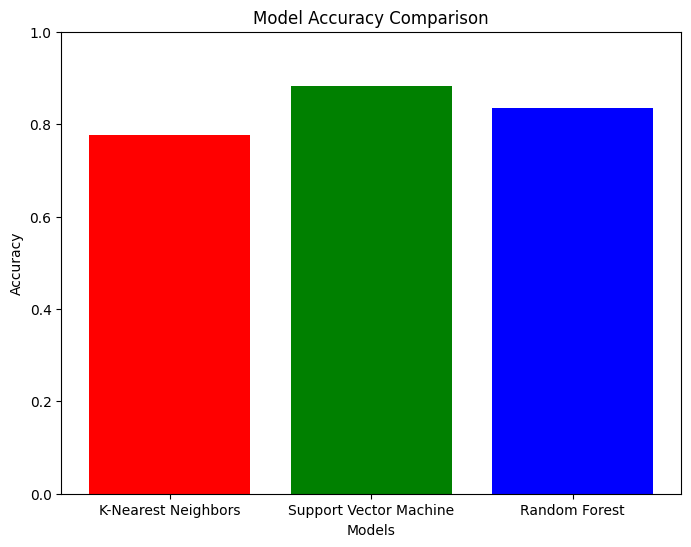

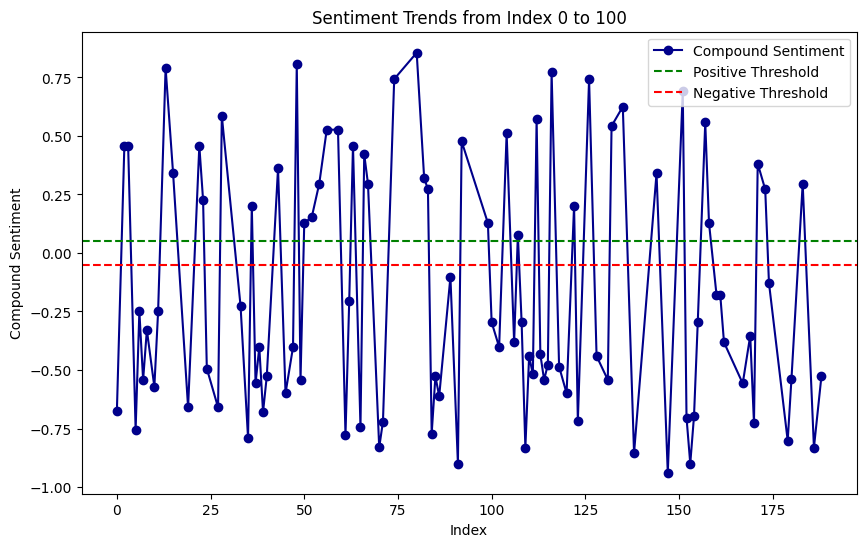

In [ ]:
import matplotlib.pyplot as plt

# Plot Model Accuracy Comparison
def plot_model_accuracy(model_accuracies):
    # models = ['KNN', 'Random Forest', 'SVM']
    # accuracies = [knn_acc, rf_acc, svm_acc]
    models = []
    accuracies = []
    for model, accuracy in model_accuracies.items():
      models.append(model)
      accuracies.append(accuracy)

    plt.figure(figsize=(8, 6))
    plt.bar(models, accuracies, color=['red', 'green', 'blue'])
    plt.ylim(0, 1)
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.show()

# Graphing Sentiment Trends Between Two Points
def plot_sentiment_trends(df, start_index, end_index):
    # Filter data
    subset = df.iloc[start_index:end_index]

    plt.figure(figsize=(10, 6))
    plt.plot(subset.index, subset['compound_sentiment'], marker='o', color='darkblue', label='Compound Sentiment')
    plt.axhline(0.05, color='green', linestyle='--', label='Positive Threshold')
    plt.axhline(-0.05, color='red', linestyle='--', label='Negative Threshold')
    plt.title(f'Sentiment Trends from Index {start_index} to {end_index}')
    plt.xlabel('Index')
    plt.ylabel('Compound Sentiment')
    plt.legend()
    plt.show()

# Calculate accuracies for provided test data
# knn_acc = calc_accuracy(knn_predicted, actual)
# rf_acc = calc_accuracy(rf_predicted, actual)
# svm_acc = calc_accuracy(svm_predicted, actual)

# Plot Model Accuracy Comparison
plot_model_accuracy(model_accuracies)

# Plot Sentiment Trends (Example: between indices 0 and 100)
plot_sentiment_trends(df, start_index=0, end_index=100)
